In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

np.random.seed(0) # Fix seed for reproducibility
random.seed(0) # Fix seed for reproducibility

In [23]:
def generate_random_graph(n=10, weight_range=(1, 10)):
    """
    Generate a random graph with n nodes and random weights
    """
    xc = np.random.rand(n + 1)*100
    yc = np.random.rand(n + 1)*100

    # Generate initial traffic matrix
    adjacency_matrix = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(n + 1):
            if i != j:
                adjacency_matrix[i, j] = np.sqrt((xc[i] - xc[j])**2 + (yc[i] - yc[j])**2)
                adjacency_matrix[j, i] = adjacency_matrix[i, j]

    return adjacency_matrix, xc, yc

# 1. Initialisation

Créez une population initiale. Cette population est généralement générée aléatoirement. Chaque individu, ou chromosome, dans cette population représente une solution possible au problème (dans ce cas, une séquence possible de livraisons pour les véhicules).

In [3]:
def create_individual(nb_truck, nb_client, starting_point=0):
    """
    Create a random individual
    """
    individual = {}
    clients = list(range(1, nb_client))
    random.shuffle(clients)
    
    groups = np.array_split(clients, nb_truck)
    for i, group in enumerate(groups):
        individual[i] = [starting_point] + list(group) + [starting_point]
    return individual

def create_population(nb_truck, nb_client, starting_point=0, size=100):
    """
    Create a population of individuals
    """
    population = []
    for i in range(size):
        population.append(create_individual(nb_truck, nb_client, starting_point))
    return population

def individual_to_lists(individual):
    """
    Convert an individual to a list of lists
    """
    # For each truck, we create a list of clients
    nodes = []
    index = []

    for truck in individual:
        nodes_of_truck = individual[truck]
        nodes += nodes_of_truck[1:-1]

        index_of_truck = truck * (len(nodes_of_truck) - 2)
        index.append(index_of_truck)

    return nodes, index

def individual_to_dict(individual_as_list, starting_point=0):
    """
    Convert an individual to a dict of lists
    """
    # For each truck, we create a list of clients
    nodes, index = individual_as_list
    individual = {}
    for i, truck in enumerate(index):
        if i == len(index) - 1:
            individual[i] = [starting_point] + nodes[truck:] + [starting_point] 
        else:
            individual[i] = [starting_point] + nodes[truck:index[i+1]] + [starting_point] 

    return individual

# population = create_population(nb_truck=3, nb_client=10, size=10)
# print(population)
individual = create_individual(nb_truck=3, nb_client=10)
print(individual)
nodes, index = individual_to_lists(individual)
print((nodes, index))
individual = individual_to_dict((nodes, index))
print(individual)

{0: [0, 8, 6, 2, 0], 1: [0, 4, 5, 3, 0], 2: [0, 1, 9, 7, 0]}
([8, 6, 2, 4, 5, 3, 1, 9, 7], [0, 3, 6])
{0: [0, 8, 6, 2, 0], 1: [0, 4, 5, 3, 0], 2: [0, 1, 9, 7, 0]}


# 2. Evaluation
Calculez la fonction de fitness pour chaque individu dans la population. La fonction de fitness détermine la qualité d'une solution. Dans le cas du VRP, cela pourrait être la distance totale parcourue par tous les véhicules.

In [4]:
def fitness(individual, adjency_matrix):
    """
    Compute the fitness of an individual
    """
    fitness = 0
    for truck in individual:
        for i in range(len(individual[truck])-1):
            fitness += adjency_matrix[individual[truck][i]][individual[truck][i+1]]
    return fitness



# 3. Selection
Sélectionnez des individus pour la reproduction. Il existe plusieurs stratégies de sélection, comme la sélection par roulette (plus la fitness d'un individu est élevée, plus il a de chances d'être sélectionné) ou la sélection par tournoi (choisissez aléatoirement quelques individus et sélectionnez le meilleur parmi eux).

In [5]:
def selection(population, adjency_matrix, k=10):
    """
    Select the best individuals in the population
    """
    population = sorted(population, key=lambda x: fitness(x, adjency_matrix))
    return population[:k]

# 4. Crossover
Créez une nouvelle génération de chromosomes en croisant les individus sélectionnés. Par exemple, en prenant la première moitié du chemin d'un parent et en complétant avec les villes restantes dans l'ordre qu'elles apparaissent dans le second parent.

In [6]:
import random

def crossover(individu1, individu2):
    """
    Crossover between two individuals
    """
    # Transform both individuals into a list
    nodes_individu1, index_individu1 = individual_to_lists(individu1)
    nodes_individu2, index_individu2 = individual_to_lists(individu2)

    # Select a random crossover point
    crossover_point = random.randint(0, len(nodes_individu1)-1)

    # Create the new individuals
    new_individu1 = nodes_individu1[:crossover_point]
    new_individu2 = nodes_individu2[:crossover_point]

    # Add the remaining nodes in the order they appear in the other parent
    for node in nodes_individu2[crossover_point:]:
        if node not in new_individu1:
            new_individu1.append(node)
    
    for node in nodes_individu1[crossover_point:]:
        if node not in new_individu2:
            new_individu2.append(node)
    
    # Transform the new individuals into a dictionary
    new_individu1 = individual_to_dict((new_individu1, index_individu1))
    new_individu2 = individual_to_dict((new_individu2, index_individu2))

    return individu1, individu2

parent1 = create_individual(nb_truck=3, nb_client=10, starting_point=0)
parent2 = create_individual(nb_truck=3, nb_client=10, starting_point=0)
child1, child2 = crossover(parent1, parent2)
print("Parent 1:", parent1)
print("Parent 2:", parent2)
print("Child:", child1)
print("Child:", child2)


Parent 1: {0: [0, 3, 1, 4, 0], 1: [0, 9, 7, 2, 0], 2: [0, 5, 6, 8, 0]}
Parent 2: {0: [0, 3, 1, 4, 0], 1: [0, 9, 7, 6, 0], 2: [0, 8, 5, 2, 0]}
Child: {0: [0, 3, 1, 4, 0], 1: [0, 9, 7, 2, 0], 2: [0, 5, 6, 8, 0]}
Child: {0: [0, 3, 1, 4, 0], 1: [0, 9, 7, 6, 0], 2: [0, 8, 5, 2, 0]}


# 4. Mutation
Apportez de petites modifications aléatoires à certains individus dans la nouvelle génération. Par exemple, en échangeant deux villes dans l'itinéraire.

In [7]:
def mutation(individual, adjency_matrix):
    """
    Mutate an individual
    """
    # Transform the individual into a list
    nodes, index = individual_to_lists(individual)

    # We need to select two clients
    client1, client2 = random.sample(range(0, len(nodes)), 2)

    # We need to swap the two clients
    nodes[client1], nodes[client2] = nodes[client2], nodes[client1]

    # Transform the new individual into a dictionary
    individual = individual_to_dict((nodes, index))

    return individual

# 5. Remplacement
Remplacez l'ancienne population par la nouvelle génération d'individus.

In [8]:
def renew_population(population, adjency_matrix, k=10, mutation_rate=0.15):
    """
    Renew the population
    """
    number_to_select = round(len(population) * k / 100)

    # Select the best individuals
    bests_individual = selection(population, adjency_matrix, k=k)

    # Create a new population
    population_reproduction = population.copy()

    # Create new individuals by crossover two by two
    for i in range(0, len(bests_individual), 2):
        parent1 = random.choice(bests_individual)
        parent2 = random.choice(bests_individual)

        child1, child2 = crossover(parent1, parent2)
        
        population_reproduction.append(child1)
        population_reproduction.append(child2)

    # Mutate the individuals
    for i in range(len(population_reproduction)):
        if random.random() < mutation_rate:
            population_reproduction[i] = mutation(population_reproduction[i], adjency_matrix)

    final_population = population_reproduction + population

    # Sort the final population
    final_population = sorted(final_population, key=lambda x: fitness(x, adjency_matrix))

    return final_population[:len(population)]
    

population = create_population(nb_truck=3, nb_client=10, size=10)

# 6. Convergence
Vérifiez si l'algorithme a atteint un critère d'arrêt. Cela peut être un nombre maximum de générations, un temps d'exécution maximal, ou un seuil de fitness. Si le critère n'est pas atteint, revenez à l'étape 2.

In [9]:
def convergence(population, adjency_matrix):
    """
    Check if the population has converged
    """
    # We need to check if all the individuals have the same fitness
    fitnesses = [fitness(individual, adjency_matrix) for individual in population]
    return len(set(fitnesses)) == 1

# 7. Run

In [11]:
def plot_graph(aadjency_matrix, xc, yc, routes):
    """
    Plot two graphs :
        - The graph of the clients
        - The graph of the routes
    On each graph represent the starting point with a bigger red circle and the clients with blue circles
    Draw each routes on the second graph with different colors
    """
    # Create a list of colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Plot the graph of the clients
    ax[0].scatter(xc, yc, s=100, c='b')
    ax[0].scatter(xc[0], yc[0], s=200, c='r')
    ax[0].set_title("Clients")

    # Plot the graph of the routes
    ax[1].scatter(xc, yc, s=100, c='b')
    ax[1].scatter(xc[0], yc[0], s=200, c='r')
    ax[1].set_title("Routes")

    # Draw the routes
    for i, route in enumerate(routes):
        ax[1].plot(xc[best_individual[route]], yc[best_individual[route]], c=colors[i%len(colors)])

    plt.show()

{0: [0, 2, 18, 11, 21, 17, 9, 0], 1: [0, 23, 27, 24, 16, 19, 25, 0], 2: [0, 15, 10, 13, 6, 5, 3, 0], 3: [0, 22, 28, 12, 29, 30, 20, 0], 4: [0, 8, 26, 14, 7, 1, 4, 0]} Distance : 1036.741557980548


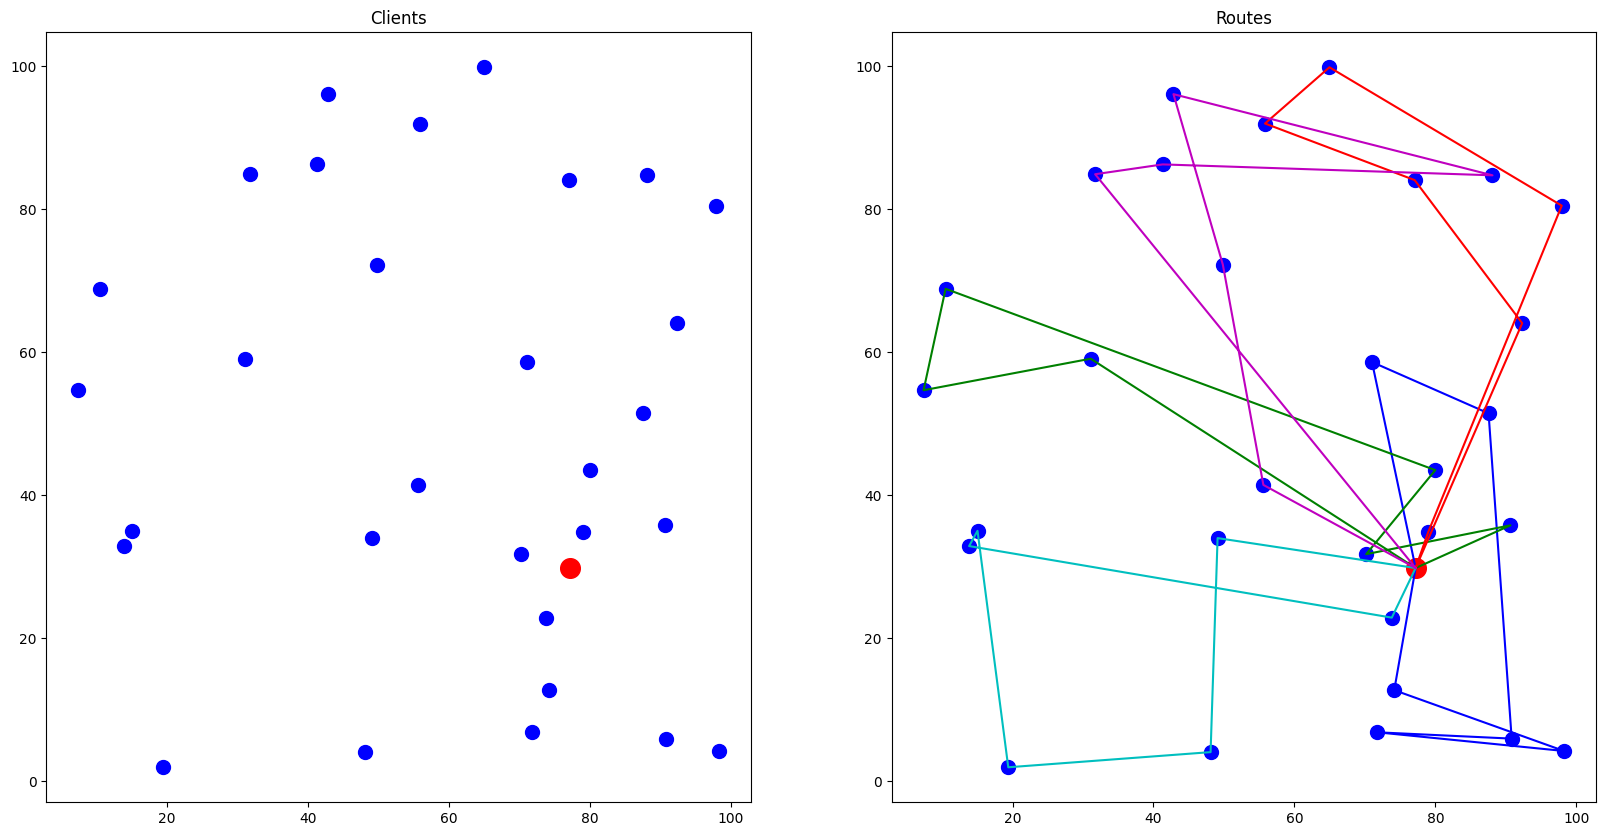

Distance of route [0, 2, 18, 11, 21, 17, 9, 0] : 181.69613246275046
Distance of route [0, 23, 27, 24, 16, 19, 25, 0] : 218.09252216640897
Distance of route [0, 15, 10, 13, 6, 5, 3, 0] : 190.26161420961617
Distance of route [0, 22, 28, 12, 29, 30, 20, 0] : 191.42866437832558
Distance of route [0, 8, 26, 14, 7, 1, 4, 0] : 255.26262476344664
Total distance : 1036.741557980548


In [32]:
def genetic_algorithm(adjency_matrix, nb_truck, starting_point=0, population_size=100, k=10, mutation_rate=0.15):
    """
    Run the genetic algorithm
    """
    # Calculate the number of clients from the adjency matrix
    nb_client = len(adjency_matrix)

    # Create the initial population
    population = create_population(nb_truck, nb_client, starting_point, population_size)
    # While the population has not converged
    t = 0
    while not convergence(population, adjency_matrix):
        # Renew the population
        population = renew_population(population, adjency_matrix, k, mutation_rate)
        t += 1
        # print("Iteration:", t, "Convergence:", convergence(population, adjency_matrix), "Best individual:", fitness(selection(population, adjency_matrix, k=1)[0], adjency_matrix))
    # Select the best individual
    best_individual = selection(population, adjency_matrix, k=1)[0]
    return best_individual

# Generate a graph
adjency_matrix, xc, yc = generate_random_graph(30)
best_individual = genetic_algorithm(adjency_matrix, nb_truck=5, starting_point=0, population_size=100, k=50, mutation_rate=0.15)
print(best_individual, "Distance :", fitness(best_individual, adjency_matrix))
plot_graph(adjency_matrix, xc, yc, best_individual)

# Calculate the distance of each route of the best individual
distances = []
for route in best_individual.values():
    d = 0
    for i in range(len(route)):
        d += adjency_matrix[route[i-1]][route[i]]
    print("Distance of route", route, ":", d)
    distances.append(d)
print("Total distance :", sum(distances))

In [140]:
# Check if an individual is valid
def is_valid(individual, adjency_matrix, starting_point=0):
    dict_client = {i:0 for i in range(len(adjency_matrix))}
    is_valid = True

    for truck, trajet in individual.items():
        # Check if the cycle starts and ends at the starting point
        if trajet[0] != starting_point or trajet[-1] != starting_point:
            is_valid = False
            break

        for vertice in trajet[1:-1]:
            dict_client[vertice] += 1

    # Check if all the clients are visited exactly once
    for client, nb_visits in dict_client.items():
        if nb_visits != 1:
            is_valid = False
            break

    return is_valid

is_valid(best_individual, adjency_matrix)

False